In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../data')
from dataLoader import loadDataframe

Import datas

In [2]:
df_movies = loadDataframe('movies')

df_characters = loadDataframe('characters')

df_clusters = loadDataframe('clusters')

df_summaries = loadDataframe('summaries')

# Data exploration

### Genres exploration

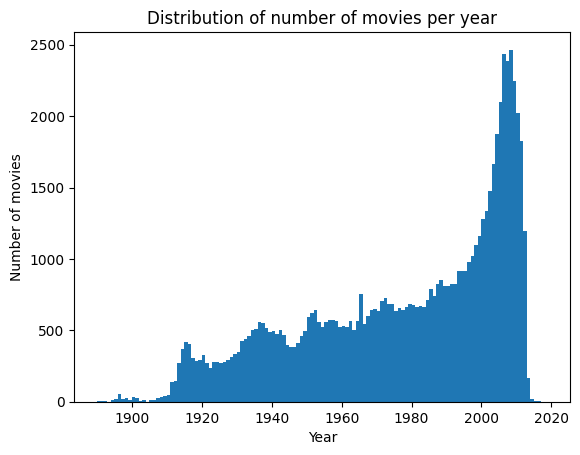

In [3]:
# Distribution of number of movies per year
plt.hist(df_movies['release_date'].dt.year, bins=range(1890, 2020, 1))
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.title('Distribution of number of movies per year')
plt.show()

In [4]:
df_genres_countries_exploded = df_movies.explode('genres').explode('countries')
df_genres_countries_exploded.head(3)

,wiki_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,countries_freebase_id,languages_freebase_id,genres_freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Thriller,['/m/09c7w0'],['/m/02h40lc'],"['/m/01jfsb', '/m/06n90', '/m/03npn', '/m/03k9..."
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Science Fiction,['/m/09c7w0'],['/m/02h40lc'],"['/m/01jfsb', '/m/06n90', '/m/03npn', '/m/03k9..."
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Horror,['/m/09c7w0'],['/m/02h40lc'],"['/m/01jfsb', '/m/06n90', '/m/03npn', '/m/03k9..."


In [6]:
df_genres_countries_exploded['genres'].unique()

array(['Thriller', 'Science Fiction', 'Horror', 'Adventure',
       'Supernatural', 'Action', 'Space western', 'Mystery',
       'Biographical film', 'Drama', 'Crime Drama', 'Crime Fiction',
       'Erotic thriller', 'Psychological thriller', 'Short Film',
       'Silent film', 'Indie', 'Black-and-white', 'Comedy', 'Family Film',
       'Fantasy', 'World cinema', 'Musical', 'Japanese Movies',
       'Action/Adventure', 'Romantic comedy', 'Ensemble Film',
       'Comedy-drama', 'Romantic drama', 'Romance Film', 'Costume drama',
       'War film', 'Epic', 'Period piece', 'Film adaptation', 'Animation',
       "Children's/Family", "Children's Fantasy", nan, 'Future noir',
       'Comedy film', 'Coming of age', 'Suspense', 'Crime Thriller',
       'Black comedy', 'Bollywood', 'Marriage Drama', 'Wuxia',
       'Martial Arts Film', 'Chinese Movies', 'Western', 'Parody',
       'Mockumentary', 'Fan film', 'Cult', 'Adventure Comedy',
       'Slapstick', 'Biopic [feature]', 'Historical Epic', '

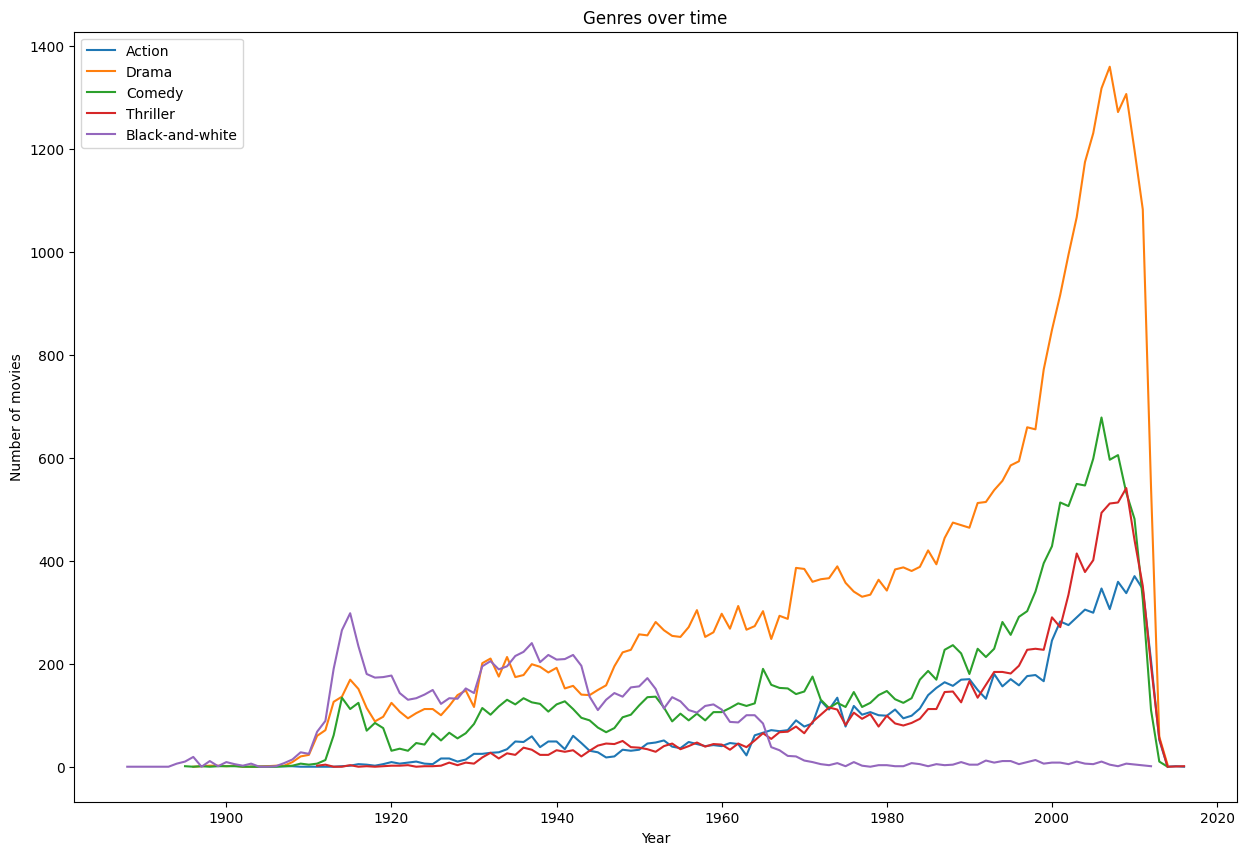

In [8]:
# Genres over time
genres = ['Action', 'Drama', 'Comedy', 'Thriller', 'Black-and-white'] 

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for genre in genres:
    df_genre = df_genres_countries_exploded[df_genres_countries_exploded['genres'] == genre]
    df_genre = df_genre.groupby(df_genre['release_date'].dt.year).size()
    df_genre.plot(ax=ax, label=genre)
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.title('Genres over time')
plt.legend()
plt.show()

In [26]:
import plotly.express as px

In [38]:
country = 'Germany'  # Specify the country
time_interval = 10
selected_genres = ['Action', 'Drama', 'Comedy', 'Thriller','World cinema', 'Horror'] 
df_country = df_genres_countries_exploded[df_genres_countries_exploded['countries'] == country]

# Calculate the number of films in each genre by year and by period
df_country['year'] = df_country['release_date'].dt.year
genre_by_year = df_country.groupby(['year', 'genres']).size().unstack().fillna(0)
genre_by_year['period'] = (genre_by_year.index // time_interval) * time_interval
genre_by_period = genre_by_year.groupby('period').sum()

# Select the genres of interest and calculate the proportion of each genre
genre_by_period_selected = genre_by_period[selected_genres]
genre_by_period_selected_proportion = genre_by_period_selected.div(genre_by_period_selected.sum(axis=1), axis=0)


# Prepare the data for Plotly
df_plot = genre_by_period_selected_proportion.reset_index().melt(id_vars='period', var_name='Genre', value_name='Proportion')

# Create the interactive stacked area plot with Plotly
fig = px.area(df_plot, x='period', y='Proportion', color='Genre',
              labels={'Proportion': 'Proportion of Films', 'period': f'Period (Every {time_interval} Years)'},
              title=f"Proportion of Selected Genres Over Time in {country} (By {time_interval}-year Periods)",
              template="plotly_dark")

# Show the plot
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

C:\Users\arnau\AppData\Local\Temp\ipykernel_20812\835484701.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Topic Modeling Bertopic

In [49]:
!pip install bertopic
!pip install sentence-transformers
!pip install nltk spacy
!python -m spacy download en_core_web_sm

  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------------- ------------------- 0.8/1.5 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.2 MB ? eta -:--:--
   --- ------------------------------------ 1.0/12.2 MB 6.3 MB/s eta 0:00:02
   -------- ------------------------------- 2.6/12.2 MB 6.9 MB/s eta 0:00:02
   ------------- -------------------------- 4.2/12.2 MB 6.8 MB/s eta 0:00:02
   -------------- ------------------------- 4.5/12.2 MB 5.4 MB/s eta 0:00:02
   ----------------- ---------------------- 5.2/12.2 MB 4.9 MB/s eta 0:00:02
   --------------------- ------------------ 6.6/12.2 MB 5.3 MB/s eta 0:00:02
   -------------------------- ------------- 8.1/12.2 MB 5.5 MB/s eta 0:00:01
   ------------------------------ -

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.0.2 which is incompatible.


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 4.2 MB/s eta 0:00:03
     ------ --------------------------------- 2.1/12.8 MB 6.2 MB/s eta 0:00:02
     --------- ------------------------------ 3.1/12.8 MB 5.4 MB/s eta 0:00:02
     ------------- -------------------------- 4.5/12.8 MB 5.7 MB/s eta 0:00:02
     ------------------ --------------------- 5.8/12.8 MB 5.7 MB/s eta 0:00:02
     ------------------ --------------------- 6.0/12.8 MB 5.0 MB/s eta 0:00:02
     --------------------- ------------------ 6.8/12.8 MB 4.7 MB/s eta 0:00:02
     ------------------------ --------------- 7.9/12.8 MB 4.8 MB/s eta 0:00:02
     --------------------------- ------------ 8.9/12.8 MB 4.9 MB/s eta 0:00:01
     ------------------------------- -------- 10.2/12.8 MB 4.8 MB/s eta 0:00:01
     ----------------------------------- ---- 11.3/12.8 MB 4.9 MB/s eta 0:00:01
     ---------------------------------------  12.6/12.8 M

In [53]:
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from tqdm import tqdm

# Load the spaCy model for English language
nlp = spacy.load("en_core_web_sm")

# Download stopwords and punkt tokenizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Load the English stopwords
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Tokenisation
    doc = nlp(text.lower())  # Convert to lowercase
    
    # Lemmatisation and remove stopwords and punctuation
    processed_tokens = [
        token.lemma_ for token in doc if token.text not in stop_words and token.text not in string.punctuation
    ]
    
    return " ".join(processed_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arnau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arnau\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [64]:
# Apply the preprocessing to the summaries
tqdm.pandas()
df_summaries['cleaned_summary'] = df_summaries['summary'].progress_apply(preprocess_text)
df_summaries.to_csv('../../data/nlpData/lemmatized_summaries.csv')

100%|██████████| 42303/42303 [40:59<00:00, 17.20it/s]  


In [65]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

In [77]:
df_summaries_small = df_summaries.sample(1000)

In [78]:
# Create the SentenceTransformer model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode the summaries
embeddings = embedding_model.encode(df_summaries_small['cleaned_summary'].tolist(), show_progress_bar=True)

# Create the BERTopic model
topic_model = BERTopic(embedding_model=embedding_model, verbose=True)

# Fit the BERTopic model
topics, probabilities = topic_model.fit_transform(df_summaries_small['cleaned_summary'].tolist())

# Assign the topics to the summaries
df_summaries_small['topic'] = topics

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2024-11-13 21:13:12,799 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2024-11-13 21:14:01,989 - BERTopic - Embedding - Completed ✓
2024-11-13 21:14:01,995 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-13 21:14:05,554 - BERTopic - Dimensionality - Completed ✓
2024-11-13 21:14:05,554 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-13 21:14:05,600 - BERTopic - Cluster - Completed ✓
2024-11-13 21:14:05,603 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-13 21:14:05,836 - BERTopic - Representation - Completed ✓


In [79]:
# Display the topics
topic_info = topic_model.get_topic_info()
print(topic_info)

# Visualize the topics
topic_model.visualize_topics()

    Topic  Count                             Name  \
0      -1    466              -1_go_take_find_one   
1       0    202              0_find_tell_go_take   
2       1    101        1_love_father_get_village   
3       2     60           2_film_war_soldier_man   
4       3     53  3_father_wife_love_relationship   
5       4     30            4_bug_tom_jerry_elmer   
6       5     23   5_murder_evans_christie_police   
7       6     23   6_dastan_tamina_michiru_dagger   
8       7     19       7_story_woman_chopin_mayil   
9       8     13     8_ship_boat_captain_finnegan   
10      9     10     9_stooge_droopy_curly_elaine   

                                       Representation  \
0   [go, take, find, one, get, leave, film, man, f...   
1   [find, tell, go, take, leave, get, see, one, k...   
2   [love, father, get, village, marry, family, ta...   
3   [film, war, soldier, man, german, d8, british,...   
4   [father, wife, love, relationship, max, life, ...   
5   [bug, tom, jerry,